In [2]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np

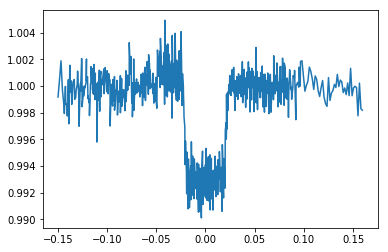

In [10]:
times, all_fluxes, err = np.loadtxt('/Users/bmmorris/git/trappist1g_spots/reduced_lcs/all_lightcurves.txt', 
                                    unpack=True)
period = 12.354473
t0 = 2450000 + 7665.35084
times = ((times - t0) % period)
times[times > period/2] -= period

all_fluxes = all_fluxes[np.argsort(times)]
times = times[np.argsort(times)]

plt.plot(times, all_fluxes)
yerr = np.std(all_fluxes[:200])

In [19]:
from batman import TransitParams
params = TransitParams()
params.per = 12.354473
params.t0 = 2450000 + 7665.35084
params.inc = 89.721
params.a = 83.5
params.rp = (0.764/100)**0.5
params.duration = 0.03620
params.b = 0.406
params.u = [0.161, 0.208]
params.w = 90
params.ecc = 0
params.limb_dark = 'quadratic'

In [20]:
from copy import deepcopy
import batman

def kipping_to_quadratic(p):
    q1, q2 = p
    u1 = 2*np.sqrt(q1)*q2
    u2 = np.sqrt(q1)*(1 - 2*q2)
    return u1, u2

def transit_model(theta, x):
    r0, r1, q1, q2, f0 = theta
    trial_params = deepcopy(params)
    trial_params.rp0 = r0
    trial_params.rp1 = r1
    trial_params.u = kipping_to_quadratic([q1, q2])
    trial_params.t0 = 0
    
    m = batman.TransitModel(trial_params, x, exp_time=x[1]-x[0], supersample_factor=3)
    fluxes = f0 * m.light_curve(trial_params)
    
    return fluxes
    
def lnlike(theta, x, y, yerr):
    r0, r1, q1, q2, f0 = theta
    model = transit_model(theta, x) 
#     inv_sigma2 = 1.0/(yerr**2 + np.exp(2*lnf))
#     return -0.5*(np.sum((model - y)**2 *inv_sigma2 - np.log(inv_sigma2)))
    return -0.5*(np.sum((model - y)**2 / yerr**2))


def lnprior(theta):
    r0, r1, q1, q2, f0 = theta
    if 0 < r0 < 1 and 0.0 < r1 < 1 and 0 < q1 < 1 and 0 < q2 < 1 and 0 < f0 < 1.5:
        return 0.0
    return -np.inf

def lnprob(theta, x, y, yerr):
    lp = lnprior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike(theta, x, y, yerr)


ndim, nwalkers = 5, 10
#pos = [[params.rp, params.rp, 0] + 1e-2*np.random.randn(ndim) for i in range(nwalkers)]
pos = []

q1 = (params.u[0] + params.u[1])**2
q2 = 0.5 * params.u[0] / (params.u[0] + params.u[1])

while len(pos) < nwalkers: 
    trial_pos = [params.rp, params.rp, q1, q2, 1] + 1e-2*np.random.randn(ndim)
    if np.isfinite(lnprior(trial_pos)):
        pos.append(trial_pos)

import emcee
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=(times, all_fluxes, yerr),
                                threads=4)

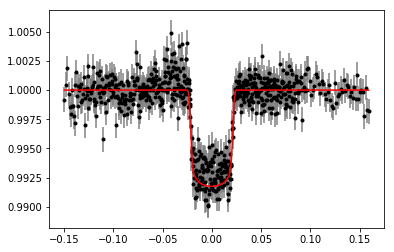

In [21]:
init_f = transit_model([params.rp, params.rp, q1, q2, 1], times)

plt.errorbar(times, all_fluxes, yerr, fmt='.', color='k', ecolor='gray')
plt.plot(times, init_f, 'r', zorder=10)

In [22]:
sampler.run_mcmc(pos, 10000); 

In [23]:
np.savetxt('trappist1g_samples.txt', sampler.flatchain)

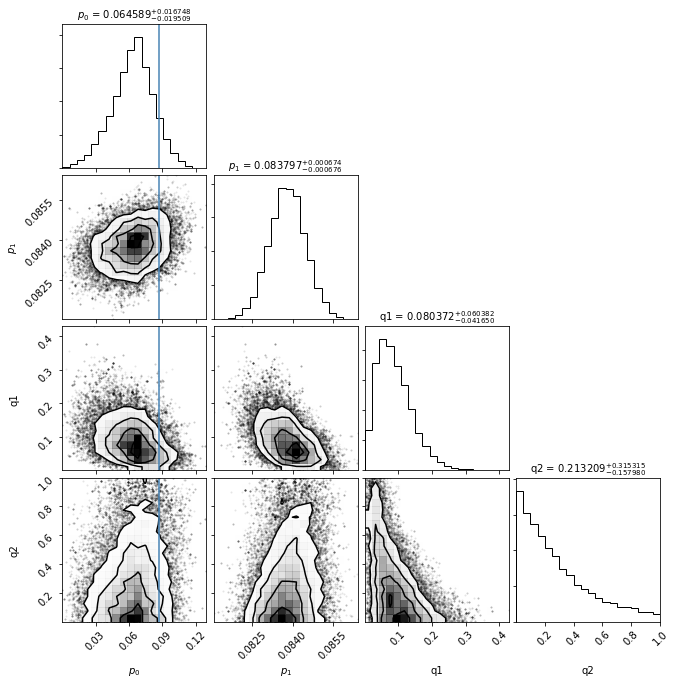

In [24]:
from corner import corner

corner(sampler.chain[:, 5000:, :-1].reshape((-1, ndim-1)), truths=[params.rp, params.rp, None, None], 
       labels=['$p_0$', '$p_1$', 'q1', 'q2'], show_titles=True, #fig=fig, 
       title_fmt='.6f', title_kwargs=dict(fontsize=10));

In [30]:
params.rp

0.08740709353364863

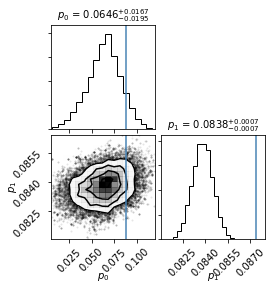

In [33]:
from corner import corner

fig, ax = plt.subplots(2, 2, figsize=(4, 4))
corner(sampler.chain[:, 5000:, :2].reshape((-1, ndim-3)), truths=[params.rp, params.rp], 
       labels=['$p_0$', '$p_1$'], fig=fig, show_titles=True, title_fmt='.4f', title_kwargs=dict(fontsize=10));

for i, axis in enumerate(fig.axes):
    axis.set_xlim([0.005, 0.12])
    if i == 3: 
        axis.set_xlim([0.081, 0.088])
plt.savefig('corner_quad_trappist1g.pdf', bbox_inches='tight')

In [34]:
# from corner import corner

# nburnin = 5000
# fig, ax = plt.subplots(2, 2, figsize=(4, 4))
# corner(sampler.chain[:, 5000:, :2].reshape((-1, ndim-2)), truths=[params.rp, params.rp], 
#        labels=['$p_0$', '$p_1$'], fig=fig, show_titles=True, title_fmt='.6f', title_kwargs=dict(fontsize=10));

# for i, axis in enumerate(fig.axes):
#     axis.set_xlim([0.09, 0.2])
#     if i == 3: 
#         axis.set_xlim([0.106, 0.12])
# plt.savefig('corner_quad_gj1214.pdf', bbox_inches='tight')

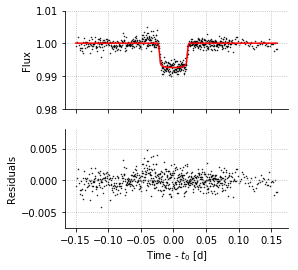

In [36]:
fig, ax = plt.subplots(2, 1, figsize=(4, 4), sharex=True)
ax[0].scatter(times, all_fluxes, marker='.', s=1, 
              color='k')

i = np.argmax(sampler.flatlnprobability, axis=0)
ax[0].plot(times, transit_model(sampler.flatchain[i, :], times), color='r')

ax[1].scatter(times, all_fluxes - transit_model(sampler.flatchain[i, :], times), 
              marker='.', s=1, 
              color='k')

ax[0].set_ylim([0.98, 1.01])
#ax[1].set_ylim([-1000, 1000])

ax[0].set_ylabel('Flux')
ax[1].set(xlabel='Time - $t_0$ [d]', ylabel='Residuals')

for axis in ax:
    for s in ['right', 'top']:
        axis.spines[s].set_visible(False)
    axis.grid(ls=':')

fig.savefig('trappist1_residuals.pdf', bbox_inches='tight', dpi=250)

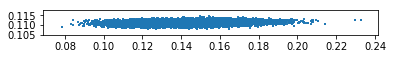

In [11]:
plt.scatter(sampler.chain[:, 5000:, 0], sampler.chain[:, 5000:, 1], marker=',', s=1)
plt.gca().set_aspect(1)

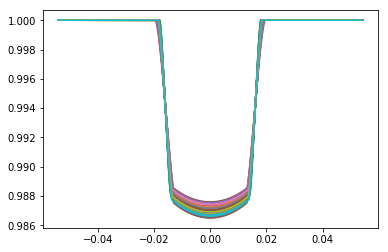

In [13]:


for i in np.random.randint(5000-sampler.chain.shape[0], size=10):
    samples_i = sampler.chain[:, (5000+i), :]
    for sample in samples_i: 
        plt.plot(times, transit_model(sample, times))

(array([   442.,   1860.,   5597.,  11074.,  18605.,  18524.,   9955.,
          3307.,    591.,     45.]),
 array([ 0.00292022,  0.16066496,  0.3184097 ,  0.47615445,  0.63389919,
         0.79164393,  0.94938868,  1.10713342,  1.26487817,  1.42262291,
         1.58036765]),
 <a list of 10 Patch objects>)

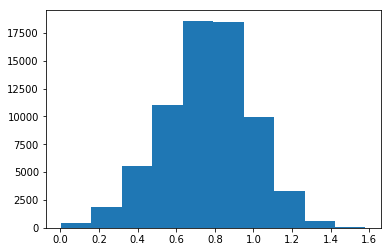

In [37]:
p0 = sampler.chain[:, 3000:, 0].ravel()
p1 = sampler.chain[:, 3000:, 1].ravel()

plt.hist(p0/p1)